<a href="https://colab.research.google.com/github/mdcramer/Eval_course_materials/blob/main/Spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding traditional ML evaluation metrics

## SMS Spam Classifier
The notebook will teach you about traditional ML evaluation metrics by building and then testing a model to detect SMS spam.

### A hands-on tutorial for Product Managers

This notebook demonstrates why accuracy isn't always the best metric
and introduces precision, recall, F1 and other evaluation metrics
through a practical spam detection example.

Learning Objectives:
1. Understand why accuracy can be misleading with imbalanced data
2. Learn about precision, recall, and F1 score
3. Explore the trade-offs between different metrics
4. Understand cost-sensitive evaluation

# Classifing SMS Spam is a real world problem

On November 12th, 2025, Google [announced](https://blog.google/outreach-initiatives/public-policy/legal-action-and-legislation-fight-scammers/) a dual strategy of legal action and new legislation to fight scammers. The Atlanta covered the news in an article about [smishing scams](https://www.theatlantic.com/technology/2025/11/smishing-scams/684905). Wired also covered the story of how [Google is suing 25 people](https://www.wired.com/story/lighthouse-google-lawsuit-scam-text-messages) it alleges are behind a “relentless” scam text operation that uses a phishing-as-a-service platform called Lighthouse. Stopping SMS spam is a real problem.

In [ ]:
# ============================================================================
# SECTION 1: Setup and Data Loading
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    matthews_corrcoef, balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os, urllib.request, zipfile

# Set random seed for reproducibility
# 42 is arbitrary but, as reference to "The Hitchhiker's Guide to the Galaxy," it's a popular choice
# Other seeds are set below, also to 42
np.random.seed(42)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [ ]:
# ----------------------------------------------------------------------------
# Load the SMS Spam Collection Dataset
# ----------------------------------------------------------------------------

# Download the dataset from official UCI Machine Learning Repository
if not os.path.exists('sms.tsv'):
    print("Downloading dataset from UCI ML Repository...")
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    urllib.request.urlretrieve(url, 'smsspam.zip')

    # Extract the zip file
    with zipfile.ZipFile('smsspam.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

    # The file is called SMSSpamCollection, rename it for consistency
    os.rename('SMSSpamCollection', 'sms.tsv')

    # Clean up
    os.remove('smsspam.zip')
    if os.path.exists('readme'):
        os.remove('readme')

    print("Dataset downloaded and extracted!")
else:
    print("Dataset already exists!")

# Load the data into a dataframe
df = pd.read_csv('sms.tsv', sep='\t', header=None, names=['label', 'message'])

# Take a look at the first few examples
print(f"\nDataset loaded: {len(df)} messages")
print(f"\nFirst few examples:")
print(df.head())

Dataset downloaded and extracted!

Dataset loaded: 5572 messages

First few examples:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
# View the full messages in the first 10 examples
with pd.option_context("display.max_colwidth", None):
    print(df.head(10))

  label  \
0   ham   
1   ham   
2  spam   
3   ham   
4   ham   
5  spam   
6   ham   
7   ham   
8  spam   
9  spam   

                                                                                                                                                            message  
0                                                   Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                     Ok lar... Joking wif u oni...  
2       Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's  
3                                                                                                                 U dun say so early hor... U c already then say...  
4                                               

In [ ]:
# View just a single entry in the dataframe
with pd.option_context("display.max_colwidth", None):
    print(df.iloc[0])

label                                                                                                                  ham
message    Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Name: 0, dtype: object



UNDERSTANDING THE DATA

Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Percentages:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64




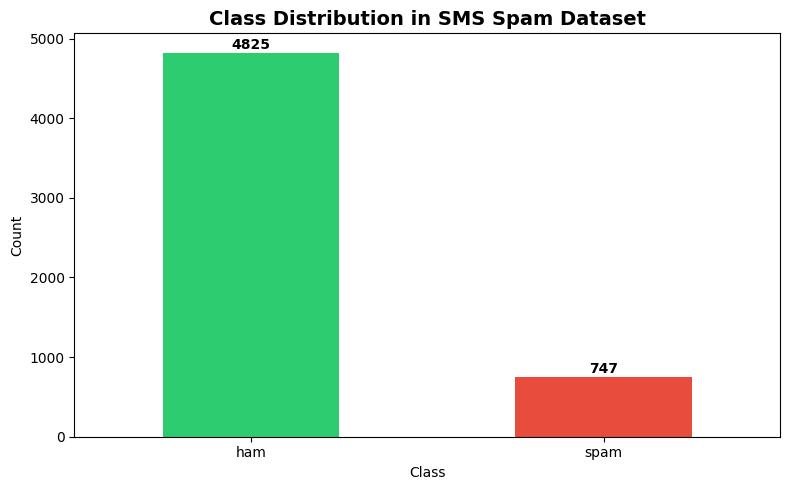


⚠️  KEY INSIGHT: This is an imbalanced dataset!
   Only 13.4% of messages are spam


In [ ]:
# ============================================================================
# SECTION 2: Exploratory Data Analysis
# ============================================================================

print("\n" + "="*60)
print("UNDERSTANDING THE DATA")
print("="*60)

# Check class distribution
class_counts = df['label'].value_counts()
print(f"\nClass Distribution:")
print(class_counts)
print(f"\nPercentages:")
print(df['label'].value_counts(normalize=True) * 100)
print(f"\n")

# Visualize class imbalance
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Class Distribution in SMS Spam Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(class_counts):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

spam_percentage = (class_counts['spam'] / len(df) * 100)
print(f"\n⚠️  KEY INSIGHT: This is an imbalanced dataset!")
print(f"   Only {spam_percentage:.1f}% of messages are spam")

In [ ]:
# ============================================================================
# SECTION 3: Data Preparation
# ============================================================================

print("\n" + "="*60)
print("PREPARING THE DATA")
print("="*60)

# Convert labels to binary (0 = ham, 1 = spam)
df['label_binary'] = (df['label'] == 'spam').astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['message'],
    df['label_binary'],
    test_size=0.25, # % of data to be allocated to the test set
    random_state=42, # seed for random number generator for reproducibility
    stratify=df['label_binary']
)

print(f"Training set: {len(X_train)} messages")
print(f"Test set: {len(X_test)} messages")
print(f"\nTest set class distribution:")
print(y_test.value_counts())

# Convert text to TF-IDF features
# TF-IDF features are numerical representations of text data that reflect the
# importance of a term within a specific message relative to an entire
# collection of messages
vectorizer = TfidfVectorizer(
    max_features=3000,
    stop_words='english',
    ngram_range=(1, 2) # create features using single and adjacent words
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\n✓ Text converted to {X_train_tfidf.shape[1]} TF-IDF features")


PREPARING THE DATA
Training set: 4179 messages
Test set: 1393 messages

Test set class distribution:
label_binary
0    1206
1     187
Name: count, dtype: int64

✓ Text converted to 3000 TF-IDF features


In [ ]:
# --- Code to inspect a specific message ---
doc_index = 6  # We want to inspect the first message
original_text = X_train.iloc[doc_index]

# 1. Extract the sparse vector for the specific message
doc_vector = X_train_tfidf[doc_index]

# 2. Get the feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()

# 3. Create a DataFrame for this single message, showing only non-zero values
# Convert the sparse row vector to a dense array (shape: [1, n_features])
# Then select the first (and only) row [0], and filter for non-zero scores.

# This approach is concise using a Pandas Series:
scores = pd.Series(doc_vector.toarray()[0], index=feature_names)
non_zero_scores = scores[scores > 0].sort_values(ascending=False)

print(f"--- Non-zero TF-IDF scores for message {doc_index} ---")
# print(f"Original Text: '{corpus[doc_index]}'\n")
print(f"Original Raw Text: '{original_text}'\n")
print(non_zero_scores)

--- Non-zero TF-IDF scores for message 6 ---
Original Raw Text: 'Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16'

100 wkly                     0.208691
ldew com1win150ppmx3age16    0.208691
tncs www                     0.202835
87066 tncs                   0.202835
entry 100                    0.198050
tncs                         0.198050
congratulations ur           0.194004
500 cd                       0.194004
ldew                         0.194004
draw txt                     0.194004
txt music                    0.194004
www ldew                     0.194004
cd                           0.190500
music 87066                  0.190500
awarded 500                  0.190500
87066                        0.182142
free entry                   0.182142
congratulations              0.179859
wkly                         0.177758
ur awarded                   0.177758
entry                 

In [ ]:
# ============================================================================
# SECTION 4: Train the Model
# ============================================================================

print("\n" + "="*60)
print("TRAINING THE MODEL")
print("="*60)

# Train a logistic regression classifier
# This is a very basic ML model. We are not using deep learning here.
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_tfidf, y_train)

print("✓ Model trained successfully!")

# Make predictions
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

# Look at some example predictions
print("\nExample predictions:")
# sample_idx = [0, 10, 50, 100, 200]
# 'size' is the parameter for the number of predictions to display
sample_idx = np.random.choice(a=len(X_test), size=10, replace=False).tolist()
# sample_idx = X_test_df.sample(n=n, replace=False).index.tolist()
for idx in sample_idx:
    message = X_test.iloc[idx]
    true_label = "SPAM" if y_test.iloc[idx] == 1 else "HAM"
    pred_label = "SPAM" if y_pred[idx] == 1 else "HAM"
    confidence = y_pred_proba[idx] if y_pred[idx] == 1 else 1 - y_pred_proba[idx]

    print(f"\n  Message: \"{message}...\"")
    print(f"  True: {true_label} | Predicted: {pred_label} | Confidence: {confidence:.2%}")


TRAINING THE MODEL
✓ Model trained successfully!

Example predictions:

  Message: "Haf u found him? I feel so stupid da v cam was working...."
  True: HAM | Predicted: HAM | Confidence: 96.19%

  Message: "You are a winner U have been specially selected 2 receive £1000 cash or a 4* holiday (flights inc) speak to a live operator 2 claim 0871277810810..."
  True: SPAM | Predicted: SPAM | Confidence: 73.06%

  Message: "Meanwhile in the shit suite: xavier decided to give us  &lt;#&gt;  seconds of warning that samantha was coming over and is playing jay's guitar to impress her or some shit. Also I don't think doug realizes I don't live here anymore..."
  True: HAM | Predicted: HAM | Confidence: 97.93%

  Message: "Final Chance! Claim ur £150 worth of discount vouchers today! Text YES to 85023 now! SavaMob, member offers mobile! T Cs SavaMob POBOX84, M263UZ. £3.00 Subs 16..."
  True: SPAM | Predicted: SPAM | Confidence: 70.19%

  Message: "Were trying to find a Chinese food place around h

In [ ]:
# ============================================================================
# SECTION 5: The "Trivial" Classifier Problem
# ============================================================================

print("\n\n" + "="*60)
print("THE PROBLEM WITH ACCURACY")
print("="*60)

# Create a "trivial" classifier that always predicts "ham"
y_pred_trivial = np.zeros_like(y_test)

# Calculate accuracy for both models
accuracy_real = accuracy_score(y_test, y_pred)
accuracy_trivial = accuracy_score(y_test, y_pred_trivial)

print(f"\n📊 Model Accuracy Comparison:")
print(f"   Real Model Accuracy:    {accuracy_real:.1%}")
print(f"   Trivial Model Accuracy: {accuracy_trivial:.1%}")

print(f"\n🤔 PROBLEM: The trivial classifier gets {accuracy_trivial:.1%} accuracy")
print(f"   just by always guessing 'ham'! This is because the dataset is imbalanced.")
print(f"\n   The trivial classifier is USELESS - it never catches spam!")
print(f"   But accuracy makes it look pretty good...")



THE PROBLEM WITH ACCURACY

📊 Model Accuracy Comparison:
   Real Model Accuracy:    97.3%
   Trivial Model Accuracy: 86.6%

🤔 PROBLEM: The trivial classifier gets 86.6% accuracy
   just by always guessing 'ham'! This is because the dataset is imbalanced.

   The trivial classifier is USELESS - it never catches spam!
   But accuracy makes it look pretty good...


# An another example of the problem with accuracy as an evaluation metric

Imagine... {to be written}



CONFUSION MATRIX: WHAT'S REALLY HAPPENING


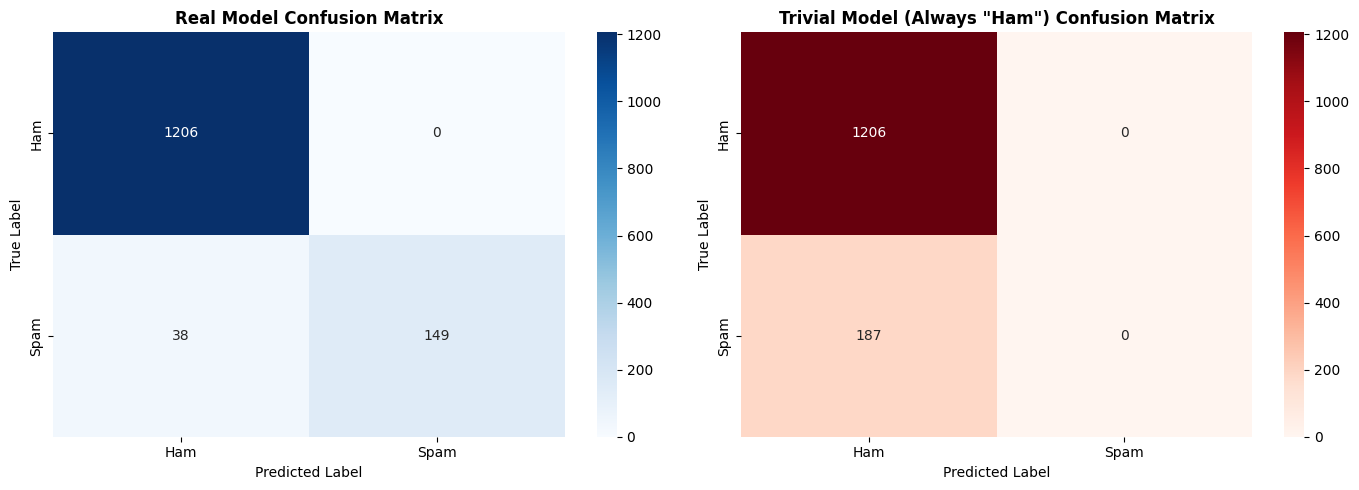


Real Model Breakdown:
  True Negatives (TN) : 1206 - Correctly identified ham
  False Positives (FP):    0 - Ham incorrectly marked as spam
  False Negatives (FN):   38 - Spam that got through
  True Positives (TP) :  149 - Correctly caught spam

💡 KEY INSIGHT: The confusion matrix shows us WHERE our model succeeds
   and fails, not just a single accuracy number.


In [ ]:
# ============================================================================
# SECTION 6: Confusion Matrix
# ============================================================================

print("\n\n" + "="*60)
print("CONFUSION MATRIX: WHAT'S REALLY HAPPENING")
print("="*60)

# Calculate confusion matrices
cm_real = confusion_matrix(y_test, y_pred)
cm_trivial = confusion_matrix(y_test, y_pred_trivial)

# Visualize confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Real model confusion matrix
sns.heatmap(cm_real, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[0].set_title('Real Model Confusion Matrix', fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Trivial model confusion matrix
sns.heatmap(cm_trivial, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[1].set_title('Trivial Model (Always "Ham") Confusion Matrix',
                  fontweight='bold', fontsize=12)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Extract values from confusion matrix
tn, fp, fn, tp = cm_real.ravel()

print(f"\nReal Model Breakdown:")
print(f"  True Negatives (TN) : {tn:4d} - Correctly identified ham")
print(f"  False Positives (FP): {fp:4d} - Ham incorrectly marked as spam")
print(f"  False Negatives (FN): {fn:4d} - Spam that got through")
print(f"  True Positives (TP) : {tp:4d} - Correctly caught spam")

print(f"\n💡 KEY INSIGHT: The confusion matrix shows us WHERE our model succeeds")
print(f"   and fails, not just a single accuracy number.")

In [ ]:
# ============================================================================
# SECTION 7: Precision and Recall
# ============================================================================

print("\n\n" + "="*60)
print("PRECISION AND RECALL")
print("="*60)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\n📊 Metrics for Real Model:")
print(f"   Precision: {precision:.1%}")
print(f"   Recall:    {recall:.1%}")

print(f"\n🎯 PRECISION = TP / (TP + FP)")
print(f"   = {tp} / ({tp} + {fp}) = {precision:.3f}")
print(f"   'Of all messages we flagged as spam, what % were actually spam?'")
print(f"   High precision = fewer false alarms")

print(f"\n🎯 RECALL = TP / (TP + FN)")
print(f"   = {tp} / ({tp} + {fn}) = {recall:.3f}")
print(f"   'Of all actual spam messages, what % did we catch?'")
print(f"   High recall = fewer spam messages slip through")

print(f"\n⚖️  THE TRADE-OFF:")
print(f"   • Want to catch ALL spam? → Optimize for RECALL")
print(f"     (But you'll get more false positives)")
print(f"   • Want to avoid false alarms? → Optimize for PRECISION")
print(f"     (But you'll miss some spam)")



PRECISION AND RECALL

📊 Metrics for Real Model:
   Precision: 100.0%
   Recall:    79.7%

🎯 PRECISION = TP / (TP + FP)
   = 149 / (149 + 0) = 1.000
   'Of all messages we flagged as spam, what % were actually spam?'
   High precision = fewer false alarms

🎯 RECALL = TP / (TP + FN)
   = 149 / (149 + 38) = 0.797
   'Of all actual spam messages, what % did we catch?'
   High recall = fewer spam messages slip through

⚖️  THE TRADE-OFF:
   • Want to catch ALL spam? → Optimize for RECALL
     (But you'll get more false positives)
   • Want to avoid false alarms? → Optimize for PRECISION
     (But you'll miss some spam)


In [ ]:
# ============================================================================
# SECTION 8: F1 Score
# ============================================================================

print("\n\n" + "="*60)
print("F1 SCORE: THE HARMONIC MEAN")
print("="*60)

f1 = f1_score(y_test, y_pred)

print(f"\nF1 Score: {f1:.1%}")
print(f"\nF1 = 2 × (Precision × Recall) / (Precision + Recall)")
print(f"   = 2 × ({precision:.3f} × {recall:.3f}) / ({precision:.3f} + {recall:.3f})")
print(f"   = {f1:.3f}")

print(f"\n💡 F1 balances precision and recall")
print(f"   • Good when you care about both false positives AND false negatives")
print(f"   • Uses harmonic mean (punishes extreme values)")
print(f"   • BUT: assumes false positives and false negatives have equal cost")



F1 SCORE: THE HARMONIC MEAN

F1 Score: 88.7%

F1 = 2 × (Precision × Recall) / (Precision + Recall)
   = 2 × (1.000 × 0.797) / (1.000 + 0.797)
   = 0.887

💡 F1 balances precision and recall
   • Good when you care about both false positives AND false negatives
   • Uses harmonic mean (punishes extreme values)
   • BUT: assumes false positives and false negatives have equal cost


In [ ]:
# ============================================================================
# SECTION 9: When F1 Isn't Enough - Cost-Sensitive Evaluation
# ============================================================================

print("\n\n" + "="*60)
print("COST-SENSITIVE EVALUATION")
print("="*60)

print(f"\n🤔 REAL-WORLD QUESTION:")
print(f"   What's worse: Missing spam or blocking legitimate email?")

# Define different cost scenarios
scenarios = [
    {'name': 'Equal Costs', 'fp_cost': 1, 'fn_cost': 1},
    {'name': 'Spam is Annoying', 'fp_cost': 1, 'fn_cost': 3},
    {'name': 'False Alarms are Terrible', 'fp_cost': 10, 'fn_cost': 1},
]

print(f"\nLet's compare different cost scenarios:")
print(f"\nConfusion Matrix Values:")
print(f"  False Positives (FP): {fp} - Ham marked as spam")
print(f"  False Negatives (FN): {fn} - Spam that got through")

for scenario in scenarios:
    scenario_name = scenario['name']
    fp_cost = scenario['fp_cost']
    fn_cost = scenario['fn_cost']
    total_cost = (fp * fp_cost) + (fn * fn_cost)
    print(f"\n  {scenario_name}:")
    print(f"    Cost per FP: ${fp_cost}, Cost per FN: ${fn_cost}")
    print(f"    Total Cost: ${total_cost}")

print(f"\n⚠️  KEY INSIGHT: F1 score assumes equal costs!")
print(f"   In real applications, you need to define your own cost function")
print(f"   based on business impact.")

# Example: Custom cost-weighted score
def custom_cost_score(y_true, y_pred, fp_cost=1, fn_cost=1):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total_cost = (fp * fp_cost) + (fn * fn_cost)
    max_cost = (tn + fp) * fp_cost + (fn + tp) * fn_cost
    return 1 - (total_cost / max_cost)

print(f"\n📊 Custom Cost-Weighted Scores:")
for scenario in scenarios:
    scenario_name = scenario['name']
    fp_cost = scenario['fp_cost']
    fn_cost = scenario['fn_cost']
    score = custom_cost_score(y_test, y_pred, fp_cost, fn_cost)
    print(f"   {scenario_name:25s}: {score:.1%}")



COST-SENSITIVE EVALUATION

🤔 REAL-WORLD QUESTION:
   What's worse: Missing spam or blocking legitimate email?

Let's compare different cost scenarios:

Confusion Matrix Values:
  False Positives (FP): 0 - Ham marked as spam
  False Negatives (FN): 38 - Spam that got through

  Equal Costs:
    Cost per FP: $1, Cost per FN: $1
    Total Cost: $38

  Spam is Annoying:
    Cost per FP: $1, Cost per FN: $3
    Total Cost: $114

  False Alarms are Terrible:
    Cost per FP: $10, Cost per FN: $1
    Total Cost: $38

⚠️  KEY INSIGHT: F1 score assumes equal costs!
   In real applications, you need to define your own cost function
   based on business impact.

📊 Custom Cost-Weighted Scores:
   Equal Costs              : 97.3%
   Spam is Annoying         : 93.5%
   False Alarms are Terrible: 99.7%


In [ ]:
# ============================================================================
# SECTION 10: Additional Metrics
# ============================================================================

print("\n\n" + "="*60)
print("OTHER USEFUL METRICS")
print("="*60)

# Calculate additional metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
specificity = tn / (tn + fp)

print(f"\n📊 Comprehensive Metric Summary:")
print(f"\n  Accuracy:          {accuracy_real:.1%}  - Can be misleading with imbalance")
print(f"  Balanced Accuracy: {balanced_acc:.1%}  - Average of recall per class")
print(f"  Precision:         {precision:.1%}  - How reliable are spam predictions?")
print(f"  Recall:            {recall:.1%}  - How much spam do we catch?")
print(f"  Specificity:       {specificity:.1%}  - How much ham do we correctly identify?")
print(f"  F1 Score:          {f1:.1%}  - Balance of precision & recall")
print(f"  ROC-AUC:           {roc_auc:.1%}  - Overall discrimination ability")
print(f"  MCC:               {mcc:.3f}  - Correlation coefficient (-1 to +1)")

print(f"\n💡 WHICH METRIC TO USE?")
print(f"   • Accuracy: Only with balanced classes")
print(f"   • Precision: When false positives are costly")
print(f"   • Recall: When false negatives are costly")
print(f"   • F1: When you need balance AND classes are imbalanced")
print(f"   • ROC-AUC: When you want threshold-independent evaluation")
print(f"   • Custom cost function: When business costs are asymmetric")



OTHER USEFUL METRICS

📊 Comprehensive Metric Summary:

  Accuracy:          97.3%  - Can be misleading with imbalance
  Balanced Accuracy: 89.8%  - Average of recall per class
  Precision:         100.0%  - How reliable are spam predictions?
  Recall:            79.7%  - How much spam do we catch?
  Specificity:       100.0%  - How much ham do we correctly identify?
  F1 Score:          88.7%  - Balance of precision & recall
  ROC-AUC:           98.8%  - Overall discrimination ability
  MCC:               0.879  - Correlation coefficient (-1 to +1)

💡 WHICH METRIC TO USE?
   • Accuracy: Only with balanced classes
   • Precision: When false positives are costly
   • Recall: When false negatives are costly
   • F1: When you need balance AND classes are imbalanced
   • ROC-AUC: When you want threshold-independent evaluation
   • Custom cost function: When business costs are asymmetric


In [ ]:
# ============================================================================
# SECTION 11: Full Classification Report
# ============================================================================

print("\n\n" + "="*60)
print("COMPLETE CLASSIFICATION REPORT")
print("="*60)

print("\n")
print(classification_report(y_test, y_pred,
                          target_names=['Ham', 'Spam'],
                          digits=3))



COMPLETE CLASSIFICATION REPORT


              precision    recall  f1-score   support

         Ham      0.969     1.000     0.984      1206
        Spam      1.000     0.797     0.887       187

    accuracy                          0.973      1393
   macro avg      0.985     0.898     0.936      1393
weighted avg      0.974     0.973     0.971      1393



# SUMMARY AND KEY TAKEAWAYS

## KEY TAKEAWAYS FOR PRODUCT MANAGERS

1. 📊 ACCURACY CAN BE MISLEADING
   • With imbalanced data, high accuracy doesn't mean good performance
   • A "trivial" classifier can achieve high accuracy by being useless
   
2. 🎯 UNDERSTAND YOUR BUSINESS COSTS
   • What's the cost of a false positive vs. false negative?
   • Different applications need different metrics
   
3. ⚖️  PRECISION VS. RECALL TRADE-OFF
   • Precision: "Don't cry wolf" - minimize false alarms
   • Recall: "Catch everything" - don't miss important cases
   • You often can't optimize both simultaneously
   
4. 🔧 CHOOSE THE RIGHT METRIC
   • Email spam: High precision (don't block real email)
   • Medical diagnosis: High recall (don't miss diseases)
   • Fraud detection: Consider custom cost functions
   
5. 📈 LOOK AT MULTIPLE METRICS
   • No single metric tells the whole story
   • Always examine the confusion matrix
   • Consider the business context

REMEMBER: The "best" model isn't *necessarily* the one with the highest accuracy!

✅ Notebook complete! Feel free to experiment with the code above and below.

In [ ]:
# ============================================================================
# SECTION 12: EXPERIMENTATION - Try It Yourself!
# ============================================================================

print("\n\n" + "="*60)
print("EXPERIMENTATION SECTION")
print("="*60)

print("""
Now it's your turn to experiment! Here are several ways to alter the model's
performance and see how different metrics change:
""")

# ----------------------------------------------------------------------------
# EXPERIMENT 1: Adjust the Decision Threshold
# ----------------------------------------------------------------------------

print("\n" + "-"*60)
print("EXPERIMENT 1: Adjusting the Decision Threshold")
print("-"*60)

print("""
By default, the model predicts 'spam' if probability > 0.5
Let's try different thresholds to trade off precision vs recall:
- Higher threshold (e.g., 0.7) → Higher precision, Lower recall
- Lower threshold (e.g., 0.3) → Lower precision, Higher recall
""")

def evaluate_with_threshold(threshold, y_test, y_pred_proba):
    """Evaluate model with custom decision threshold"""
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred_custom)
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)

    print(f"\nThreshold: {threshold:.2f}")
    print(f"  Accuracy:  {acc:.1%}")
    print(f"  Precision: {prec:.1%}")
    print(f"  Recall:    {rec:.1%}")
    print(f"  F1 Score:  {f1:.1%}")

    return y_pred_custom

# Try different thresholds
print("\n🔬 Comparing Different Thresholds:")
thresholds = [0.1, 0.2, 0.4, 0.5, 0.7, 0.9]
for thresh in thresholds:
    evaluate_with_threshold(thresh, y_test, y_pred_proba)

print("\n💡 OBSERVATION: Notice how precision increases and recall decreases")
print("   as you raise the threshold!")



EXPERIMENTATION SECTION

Now it's your turn to experiment! Here are several ways to alter the model's
performance and see how different metrics change:


------------------------------------------------------------
EXPERIMENT 1: Adjusting the Decision Threshold
------------------------------------------------------------

By default, the model predicts 'spam' if probability > 0.5
Let's try different thresholds to trade off precision vs recall:
- Higher threshold (e.g., 0.7) → Higher precision, Lower recall
- Lower threshold (e.g., 0.3) → Lower precision, Higher recall


🔬 Comparing Different Thresholds:

Threshold: 0.10
  Accuracy:  92.2%
  Precision: 64.0%
  Recall:    96.8%
  F1 Score:  77.0%

Threshold: 0.20
  Accuracy:  97.6%
  Precision: 88.9%
  Recall:    94.1%
  F1 Score:  91.4%

Threshold: 0.40
  Accuracy:  98.2%
  Precision: 99.4%
  Recall:    87.2%
  F1 Score:  92.9%

Threshold: 0.50
  Accuracy:  97.3%
  Precision: 100.0%
  Recall:    79.7%
  F1 Score:  88.7%

Threshold: 0.


📊 Visualizing the Precision-Recall Tradeoff:


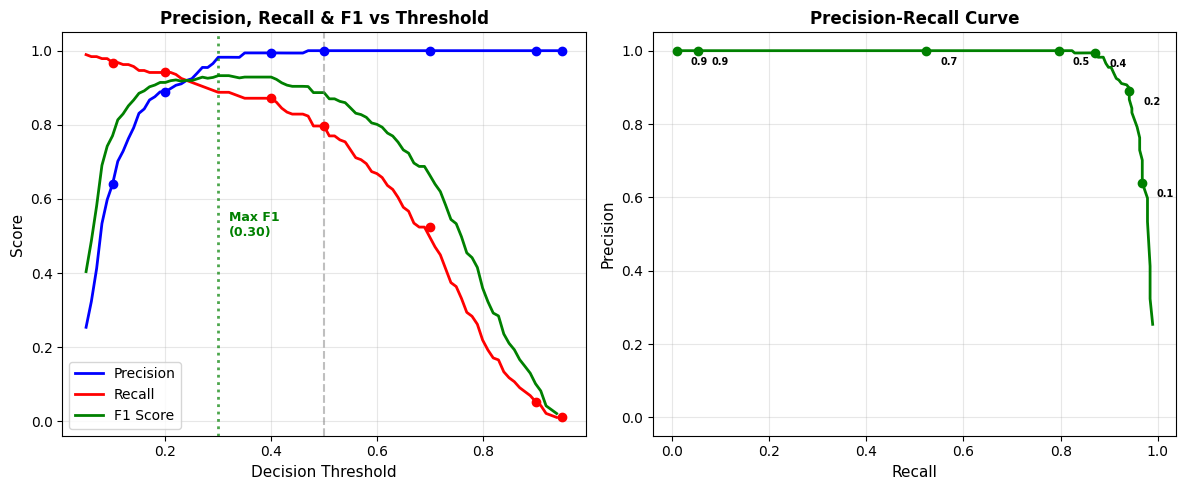


💡 KEY INSIGHTS FROM THE PLOTS:
   LEFT: As threshold increases, precision ↑ and recall ↓
   RIGHT: The curve shows the fundamental precision/recall tradeoff
   • Top-left = High precision, low recall (few false alarms)
   • Bottom-right = Low precision, high recall (catch everything)


In [ ]:
# Visualize the precision-recall tradeoff across many thresholds
print("\n📊 Visualizing the Precision-Recall Tradeoff:")

# Test many thresholds from 0.1 to 0.9
start_thresh_range = 0.05
end_thresh_range = 0.95
threshold_range = np.arange(start_thresh_range, end_thresh_range, 0.01)
precisions_list = []
recalls_list = []
f1_list = []

for thresh in threshold_range:
    y_pred_temp = (y_pred_proba >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_temp, zero_division=0)
    rec = recall_score(y_test, y_pred_temp, zero_division=0)
    f1_val = f1_score(y_test, y_pred_temp, zero_division=0)
    precisions_list.append(prec)
    recalls_list.append(rec)
    f1_list.append(f1_val)

# Create the plot
plt.figure(figsize=(12, 5))

# Left plot: Precision and Recall vs Threshold
plt.subplot(1, 2, 1)
plt.plot(threshold_range, precisions_list, 'b-', linewidth=2, label='Precision')
plt.plot(threshold_range, recalls_list, 'r-', linewidth=2, label='Recall')
plt.plot(threshold_range, f1_list, 'g-', linewidth=2, label='F1 Score')
plt.xlabel('Decision Threshold', fontsize=11)
plt.ylabel('Score', fontsize=11)
plt.title('Precision, Recall & F1 vs Threshold', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

# Mark the thresholds we tested
for thresh in thresholds:
    idx = int((thresh - start_thresh_range) / 0.01)
    if idx < len(precisions_list):
        plt.plot(thresh, precisions_list[idx], 'bo', markersize=6)
        plt.plot(thresh, recalls_list[idx], 'ro', markersize=6)

# Find and mark the optimal F1 threshold
optimal_f1_idx = np.argmax(f1_list)
optimal_threshold = threshold_range[optimal_f1_idx]
plt.axvline(x=optimal_threshold, color='green', linestyle=':', linewidth=2, alpha=0.7)
plt.text(optimal_threshold + 0.02, 0.5, f'Max F1\n({optimal_threshold:.2f})',
         fontsize=9, color='green', fontweight='bold')

# Right plot: Precision vs Recall curve
plt.subplot(1, 2, 2)
plt.plot(recalls_list, precisions_list, 'g-', linewidth=2)
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('Precision-Recall Curve', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(-0.05,1.05)

# Mark the thresholds we tested
for thresh in thresholds:
    idx = int((thresh - start_thresh_range) / 0.01)
    if idx < len(precisions_list):
        plt.plot(recalls_list[idx], precisions_list[idx], 'go', markersize=6)
        plt.annotate(f'{thresh:.1f}',
                    xy=(recalls_list[idx], precisions_list[idx]),
                    xytext=(10, -10), textcoords='offset points',
                    fontsize=7, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS FROM THE PLOTS:")
print("   LEFT: As threshold increases, precision ↑ and recall ↓")
print("   RIGHT: The curve shows the fundamental precision/recall tradeoff")
print("   • Top-left = High precision, low recall (few false alarms)")
print("   • Bottom-right = Low precision, high recall (catch everything)")

In [ ]:
# ----------------------------------------------------------------------------
# EXPERIMENT 2: Train a Worse Model (Fewer Features)
# ----------------------------------------------------------------------------

print("\n\n" + "-"*60)
print("EXPERIMENT 2: Train with Fewer Features")
print("-"*60)

print("""
Let's train a model with only 100 features instead of 3000.
This should perform worse and help illustrate metric differences.
""")

# Create a simpler model with fewer features
vectorizer_simple = TfidfVectorizer(
    max_features=100,  # Much fewer features!
    stop_words='english',
    ngram_range=(1, 1)  # Only unigrams
)

X_train_simple = vectorizer_simple.fit_transform(X_train)
X_test_simple = vectorizer_simple.transform(X_test)

model_simple = LogisticRegression(random_state=42, max_iter=1000)
model_simple.fit(X_train_simple, y_train)

y_pred_simple = model_simple.predict(X_test_simple)

print("\n🔬 Comparing Full Model vs Simple Model:")
print("\nFull Model (3000 features):")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred):.1%}")
print(f"  Precision: {precision_score(y_test, y_pred):.1%}")
print(f"  Recall:    {recall_score(y_test, y_pred):.1%}")
print(f"  F1 Score:  {f1_score(y_test, y_pred):.1%}")

print("\nSimple Model (100 features):")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_simple):.1%}")
print(f"  Precision: {precision_score(y_test, y_pred_simple):.1%}")
print(f"  Recall:    {recall_score(y_test, y_pred_simple):.1%}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_simple):.1%}")



------------------------------------------------------------
EXPERIMENT 2: Train with Fewer Features
------------------------------------------------------------

Let's train a model with only 100 features instead of 3000.
This should perform worse and help illustrate metric differences.


🔬 Comparing Full Model vs Simple Model:

Full Model (3000 features):
  Accuracy:  97.3%
  Precision: 100.0%
  Recall:    79.7%
  F1 Score:  88.7%

Simple Model (100 features):
  Accuracy:  96.1%
  Precision: 97.2%
  Recall:    73.3%
  F1 Score:  83.5%


In [ ]:
# ----------------------------------------------------------------------------
# EXPERIMENT 3: Add Class Weights (Handle Imbalance)
# ----------------------------------------------------------------------------

print("\n\n" + "-"*60)
print("EXPERIMENT 3: Using Class Weights")
print("-"*60)

print("""
We can tell the model that spam is more important by using class weights.
This typically increases recall (catches more spam) but may decrease precision.
""")

# Train model with class weights
model_weighted = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Automatically balance classes
)
model_weighted.fit(X_train_tfidf, y_train)

y_pred_weighted = model_weighted.predict(X_test_tfidf)

print("\n🔬 Comparing Unweighted vs Weighted Model:")
print("\nOriginal Model (no class weights):")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred):.1%}")
print(f"  Precision: {precision_score(y_test, y_pred):.1%}")
print(f"  Recall:    {recall_score(y_test, y_pred):.1%}")
print(f"  F1 Score:  {f1_score(y_test, y_pred):.1%}")

print("\nWeighted Model (balanced classes):")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_weighted):.1%}")
print(f"  Precision: {precision_score(y_test, y_pred_weighted):.1%}")
print(f"  Recall:    {recall_score(y_test, y_pred_weighted):.1%}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_weighted):.1%}")

print("\n💡 OBSERVATION: Class weights often increase recall at the cost of precision!")



------------------------------------------------------------
EXPERIMENT 3: Using Class Weights
------------------------------------------------------------

We can tell the model that spam is more important by using class weights.
This typically increases recall (catches more spam) but may decrease precision.


🔬 Comparing Unweighted vs Weighted Model:

Original Model (no class weights):
  Accuracy:  97.3%
  Precision: 100.0%
  Recall:    79.7%
  F1 Score:  88.7%

Weighted Model (balanced classes):
  Accuracy:  97.8%
  Precision: 91.1%
  Recall:    92.5%
  F1 Score:  91.8%

💡 OBSERVATION: Class weights often increase recall at the cost of precision!


In [ ]:
# ----------------------------------------------------------------------------
# EXPERIMENT 4: Custom Class Weights
# ----------------------------------------------------------------------------

print("\n\n" + "-"*60)
print("EXPERIMENT 4: Custom Class Weights")
print("-"*60)

print("""
You can specify custom weights to control the precision/recall tradeoff.
Higher weight on spam (class 1) → Higher recall, Lower precision
""")

# Try different custom weights
# 'weights': {0: 1, 1: 10} assigns a weights of 1 and 10 to classes 0 and 1, respectively
weight_scenarios = [
    {'name': 'Favor Precision', 'weights': {0: 1, 1: 1}},
    {'name': 'Favor Recall', 'weights': {0: 1, 1: 5}},
    {'name': 'Strongly Favor Recall', 'weights': {0: 1, 1: 10}},
]

print("\n🔬 Comparing Different Class Weight Strategies:")
for scenario in weight_scenarios:
    model_custom = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight=scenario['weights']
    )
    model_custom.fit(X_train_tfidf, y_train)
    y_pred_custom = model_custom.predict(X_test_tfidf)

    print(f"\n{scenario['name']} (weights: {scenario['weights']}):")
    print(f"  Precision: {precision_score(y_test, y_pred_custom):.1%}")
    print(f"  Recall:    {recall_score(y_test, y_pred_custom):.1%}")
    print(f"  F1 Score:  {f1_score(y_test, y_pred_custom):.1%}")



------------------------------------------------------------
EXPERIMENT 4: Custom Class Weights
------------------------------------------------------------

You can specify custom weights to control the precision/recall tradeoff.
Higher weight on spam (class 1) → Higher recall, Lower precision


🔬 Comparing Different Class Weight Strategies:

Favor Precision (weights: {0: 1, 1: 1}):
  Precision: 100.0%
  Recall:    79.7%
  F1 Score:  88.7%

Favor Recall (weights: {0: 1, 1: 5}):
  Precision: 93.5%
  Recall:    92.5%
  F1 Score:  93.0%

Strongly Favor Recall (weights: {0: 1, 1: 10}):
  Precision: 88.4%
  Recall:    94.1%
  F1 Score:  91.2%




------------------------------------------------------------
EXPERIMENT 5: Precision-Recall Curve
------------------------------------------------------------


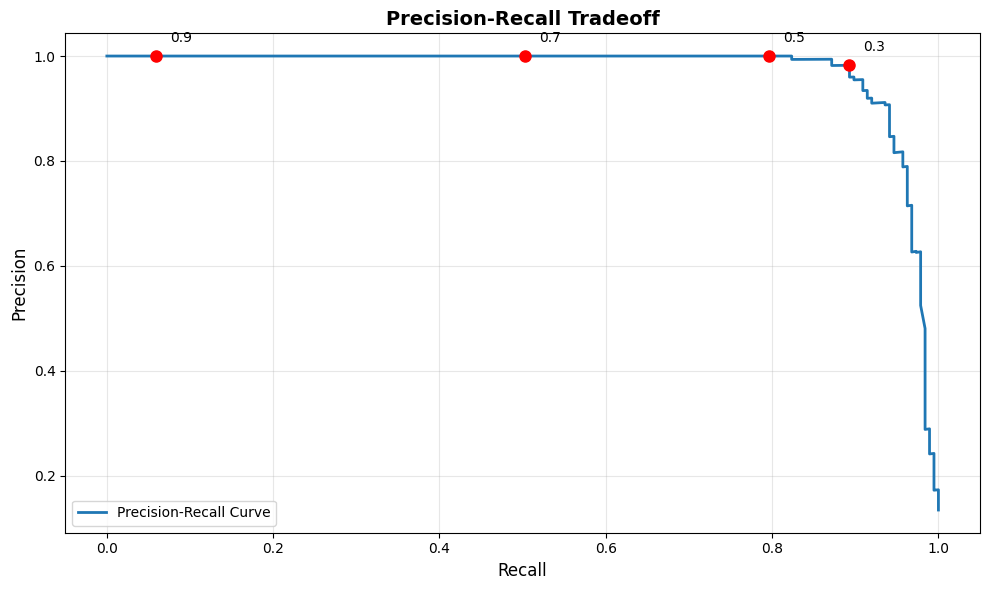


💡 This curve shows ALL possible precision/recall combinations!
   Each point represents a different decision threshold.


In [ ]:
# ----------------------------------------------------------------------------
# EXPERIMENT 5: Visualize Precision-Recall Tradeoff
# ----------------------------------------------------------------------------

print("\n\n" + "-"*60)
print("EXPERIMENT 5: Precision-Recall Curve")
print("-"*60)

from sklearn.metrics import precision_recall_curve

# Calculate precision and recall for different thresholds
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, linewidth=2, label='Precision-Recall Curve')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Tradeoff', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Mark some specific thresholds
sample_thresholds = [0.3, 0.5, 0.7, 0.9]
for thresh in sample_thresholds:
    idx = (np.abs(thresholds_pr - thresh)).argmin()
    plt.plot(recalls[idx], precisions[idx], 'ro', markersize=8)
    plt.annotate(f'{thresh:.1f}',
                xy=(recalls[idx], precisions[idx]),
                xytext=(10, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

print("\n💡 This curve shows ALL possible precision/recall combinations!")
print("   Each point represents a different decision threshold.")

In [ ]:
# ----------------------------------------------------------------------------
# YOUR TURN!
# ----------------------------------------------------------------------------

print("\n\n" + "="*60)
print("NOW IT'S YOUR TURN TO EXPERIMENT!")
print("="*60)

print("""
Try modifying the code above to answer these questions:

1. What threshold gives you 95% precision? What's the recall at that point?

2. If missing spam costs $10 and false alarms cost $1, which model performs best?
   (Hint: Use the custom_cost_score function from Section 9)

3. What happens if you train with only 50 features? Or 10 features?

4. Can you find a threshold where precision and recall are exactly equal?

5. Create a model that achieves at least 90% recall. What's the precision?

6. Which is better for email spam filtering: the original model or the
   balanced class weight model? Why?

REMEMBER: There's no single "best" model - it depends on your business needs!
""")